# Problem description

You are to predict whether a company will go bankrupt in the following year, based on financial attributes of the company.

Perhaps you are contemplating lending money to a company, and need to know whether the company
is in near-term danger of not being able to repay.


## Goal

## Learning objectives

- Demonstrate mastery on solving a classification problem and presenting
the entire Recipe for Machine Learning process in a notebook.
- We will make suggestions for ways to approach the problem
    - But there will be little explicit direction for this task.
- It is meant to be analogous to a pre-interview task that a potential employer might assign
to verify your skill

# Import modules

In [1]:
## Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn

import os
import math

%matplotlib inline


# API for students

In [2]:
## Load the bankruptcy_helper module

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

# Import bankruptcy_helper module
import bankruptcy_helper
%aimport bankruptcy_helper

helper = bankruptcy_helper.Helper()

# Get the data

The first step in our Recipe is Get the Data.

- Each example is a row of data corresponding to a single company
- There are 64 attributes, described in the section below
- The column `Bankrupt` is 1 if the company subsequently went bankrupt; 0 if it did not go bankrupt
- The column `Id` is a Company Identifier

In [3]:
# Data directory
DATA_DIR = "./Data"

if not os.path.isdir(DATA_DIR):
    DATA_DIR = "../resource/asnlib/publicdata/bankruptcy/data"

data_file = "5th_yr.csv"
data = pd.read_csv( os.path.join(DATA_DIR, "train", data_file) )

target_attr = "Bankrupt"

n_samples, n_attrs = data.shape
print("Date shape: ", data.shape)

Date shape:  (4818, 66)


## Have a look at the data

We will not go through all steps in the Recipe, nor in depth.

But here's a peek

In [4]:
data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X57,X58,X59,X60,X61,X62,X63,X64,Bankrupt,Id
0,0.025417,0.41769,0.0568,1.1605,-126.39,0.41355,0.025417,1.2395,1.16500,0.51773,...,0.049094,0.85835,0.12322,5.6167,7.4042,164.310,2.2214,1.334,0,4510
1,-0.023834,0.2101,0.50839,4.2374,22.034,0.058412,-0.027621,3.6579,0.98183,0.76855,...,-0.031011,1.01850,0.069047,5.7996,7.7529,26.446,13.802,6.4782,0,3537
2,0.030515,0.44606,0.19569,1.565,35.766,0.28196,0.039264,0.88456,1.05260,0.39457,...,0.077337,0.95006,0.25266,15.049,2.8179,104.730,3.4852,2.6361,0,3920
3,0.052318,0.056366,0.54562,10.68,438.2,0.13649,0.058164,10.853,1.02790,0.61173,...,0.085524,0.97282,0,6.0157,7.4626,48.756,7.4863,1.0602,0,1806
4,0.000992,0.49712,0.12316,1.3036,-71.398,0,0.001007,1.0116,1.29210,0.50288,...,0.001974,0.99925,0.019736,3.4819,8.582,114.580,3.1854,2.742,0,1529


Pretty *unhelpful* !

What are these mysteriously named features ?

## Description of attributes

This may still be somewhat unhelpful for those of you not used to reading Financial Statements.

But that's partially the point of the exercise
- You can *still* perform Machine Learning *even if* you are not an expert in the problem domain
    - That's what makes this a good interview exercise: you can demonstrate your thought process even if you don't know the exact meaning of the terms
- Of course: becoming an expert in the domain *will improve* your ability to create better models
    - Feature engineering is easier if you understand the features, their inter-relationships, and the relationship to the target

Let's get a feel for the data
- What is the type of each attribute ?


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4818 entries, 0 to 4817
Data columns (total 66 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   X1        4818 non-null   object 
 1   X2        4818 non-null   object 
 2   X3        4818 non-null   object 
 3   X4        4818 non-null   object 
 4   X5        4818 non-null   object 
 5   X6        4818 non-null   object 
 6   X7        4818 non-null   object 
 7   X8        4818 non-null   object 
 8   X9        4818 non-null   float64
 9   X10       4818 non-null   object 
 10  X11       4818 non-null   object 
 11  X12       4818 non-null   object 
 12  X13       4818 non-null   float64
 13  X14       4818 non-null   object 
 14  X15       4818 non-null   object 
 15  X16       4818 non-null   object 
 16  X17       4818 non-null   object 
 17  X18       4818 non-null   object 
 18  X19       4818 non-null   float64
 19  X20       4818 non-null   float64
 20  X21       4818 non-null   obje

You may be puzzled:
- Most attributes are `object` and *not* numeric (`float64`)
- But looking at the data via `data.head()` certainly gives the impression that all attributes are numeric

Welcome to the world of messy data !  The dataset has represented numbers as strings.
- These little unexpected challenges are common in the real-word
- Data is rarely perfect and clean

So you might want to first convert all attributes to numeric

**Hint**
- Look up the Pandas method `to_numeric`
    - We suggest you use the option `errors='coerce'`
    

# Evaluating your project

We will evaluate your submission on a test dataset that we provide
- It has no labels, so **you** can't use it to evaluate your model, but **we** have the labels
- We will call this evaluation dataset the "holdout" data

Let's get it

In [6]:
holdout_data = pd.read_csv( os.path.join(DATA_DIR, "holdout", '5th_yr.csv') )

print("Data shape: ", holdout_data.shape)


Data shape:  (1092, 65)


We will evaluate your model on the holdout examples using metrics
- Accuracy
- Recall
- Precision

From our lecture: we may have to make a trade-off between Recall and Precision.

Our evaluation of your submission will be partially based on how you made (and described) the trade-off.

You may assume that it is 5 times worse to *fail to identify a company that will go bankrupt*
than it is to fail to identify a company that won't go bankrupt.

# Your model

Time for you to continue the Recipe for Machine Learning on your own.



## Submission guidelines

Although your notebook may contain many models (e.g., due to your iterative development)
we will only evaluate a single model.
So choose one (explain why !) and do the following.

- You will implement the body of a subroutine `MyModel`
    - That takes as argument a Pandas DataFrame 
        - Each row is an example on which to predict
        - The features of the example are elements of the row
    - Performs predictions on each example
    - Returns an array or predictions with a one-to-one correspondence with the examples in the test set
    

We will evaluate your model against the holdout data
- By reading the holdout examples `X_hold` (as above)
- Calling `y_hold_pred = MyModel(X_hold)` to get the predictions
- Comparing the predicted values `y_hold_pred` against the true labels `y_hold` which are known only to the instructors

See the following cell as an illustration

**Remember**

The holdout data is in the same format as the one we used for training
- Except that it has no attribute for the target
- So you will need to perform all the transformations on the holdout data
    - As you did on the training data
    - Including turning the string representation of numbers into actual numeric data types

All of this work *must* be performed within the body of the `MyModel` routine you will write

We will grade you by comparing the predictions array you create to the answers known to us.

In [7]:
import pandas as pd
import os
from sklearn.impute import SimpleImputer 

# Convert all attributes to numeric
data = data.apply(pd.to_numeric, errors='coerce')
data.head()
data.info()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X57,X58,X59,X60,X61,X62,X63,X64,Bankrupt,Id
0,0.025417,0.417690,0.05680,1.1605,-126.390,0.413550,0.025417,1.23950,1.16500,0.51773,...,0.049094,0.85835,0.123220,5.6167,7.4042,164.310,2.2214,1.3340,0,4510
1,-0.023834,0.210100,0.50839,4.2374,22.034,0.058412,-0.027621,3.65790,0.98183,0.76855,...,-0.031011,1.01850,0.069047,5.7996,7.7529,26.446,13.8020,6.4782,0,3537
2,0.030515,0.446060,0.19569,1.5650,35.766,0.281960,0.039264,0.88456,1.05260,0.39457,...,0.077337,0.95006,0.252660,15.0490,2.8179,104.730,3.4852,2.6361,0,3920
3,0.052318,0.056366,0.54562,10.6800,438.200,0.136490,0.058164,10.85300,1.02790,0.61173,...,0.085524,0.97282,0.000000,6.0157,7.4626,48.756,7.4863,1.0602,0,1806
4,0.000992,0.497120,0.12316,1.3036,-71.398,0.000000,0.001007,1.01160,1.29210,0.50288,...,0.001974,0.99925,0.019736,3.4819,8.5820,114.580,3.1854,2.7420,0,1529


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4818 entries, 0 to 4817
Data columns (total 66 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   X1        4816 non-null   float64
 1   X2        4816 non-null   float64
 2   X3        4816 non-null   float64
 3   X4        4803 non-null   float64
 4   X5        4808 non-null   float64
 5   X6        4816 non-null   float64
 6   X7        4816 non-null   float64
 7   X8        4804 non-null   float64
 8   X9        4818 non-null   float64
 9   X10       4816 non-null   float64
 10  X11       4816 non-null   float64
 11  X12       4803 non-null   float64
 12  X13       4818 non-null   float64
 13  X14       4816 non-null   float64
 14  X15       4812 non-null   float64
 15  X16       4804 non-null   float64
 16  X17       4804 non-null   float64
 17  X18       4816 non-null   float64
 18  X19       4818 non-null   float64
 19  X20       4818 non-null   float64
 20  X21       4744 non-null   floa

In [8]:
data = data.fillna(0)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4818 entries, 0 to 4817
Data columns (total 66 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   X1        4818 non-null   float64
 1   X2        4818 non-null   float64
 2   X3        4818 non-null   float64
 3   X4        4818 non-null   float64
 4   X5        4818 non-null   float64
 5   X6        4818 non-null   float64
 6   X7        4818 non-null   float64
 7   X8        4818 non-null   float64
 8   X9        4818 non-null   float64
 9   X10       4818 non-null   float64
 10  X11       4818 non-null   float64
 11  X12       4818 non-null   float64
 12  X13       4818 non-null   float64
 13  X14       4818 non-null   float64
 14  X15       4818 non-null   float64
 15  X16       4818 non-null   float64
 16  X17       4818 non-null   float64
 17  X18       4818 non-null   float64
 18  X19       4818 non-null   float64
 19  X20       4818 non-null   float64
 20  X21       4818 non-null   floa

In [9]:
X_data = data.loc[:,'X1':'X64']
y_data = data.loc[:, 'Bankrupt']
print("X_data shape: ", X_data.shape, ", y_data shape: ", y_data.shape)

X_data shape:  (4818, 64) , y_data shape:  (4818,)


In [10]:
from sklearn.model_selection import train_test_split
# Create test set
X_data_train, X_data_test, y_data_train, y_data_test = train_test_split(X_data, y_data, test_size=0.2, random_state=12)
print("X_data_train shape: ", X_data_train.shape, ", X_data_test shape: ", X_data_test.shape)
print("y_data_train shape: ", y_data_train.shape, ", y_data_test shape: ", y_data_test.shape)

X_data_train shape:  (3854, 64) , X_data_test shape:  (964, 64)
y_data_train shape:  (3854,) , y_data_test shape:  (964,)


## Exploratory Data Analysis

After getting the data, we will see the **correlations** between 64 features. The data have 64 festures, which is quite a lot. So, we want to reduce the number of features.

In [11]:
X_data.describe()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X55,X56,X57,X58,X59,X60,X61,X62,X63,X64
count,4818.000000,4818.000000,4818.000000,4818.000000,4.818000e+03,4818.000000,4818.000000,4818.000000,4818.000000,4818.000000,...,4.818000e+03,4818.000000,4818.000000,4818.000000,4818.000000,4.818000e+03,4818.000000,4818.000000,4818.000000,4818.000000
mean,-0.055209,0.533051,0.188914,4.963102,1.952380e+01,-0.070031,-0.042498,5.723306,1.579277,0.503397,...,1.074023e+04,0.056109,0.022784,0.959585,0.272912,1.058165e+03,10.993853,177.494445,9.258716,37.893300
std,6.705958,1.202709,1.282170,100.118089,2.382015e+04,7.776908,6.706577,109.349186,1.342723,4.043209,...,8.284685e+04,0.755462,7.247517,0.932427,6.337287,6.942421e+04,43.769977,2279.713700,113.050677,583.639554
min,-463.890000,0.000000,-72.067000,0.000000,-1.076400e+06,-463.890000,-463.890000,-3.735100,0.000191,-71.444000,...,-1.118500e+06,-46.788000,-468.670000,-0.085920,-184.980000,-1.244000e+01,-0.092493,0.000000,0.000000,-3.726500
25%,0.004042,0.254587,0.044859,1.093475,-4.290075e+01,0.000000,0.005977,0.477145,1.015600,0.318728,...,9.771450e+01,0.011478,0.015447,0.876940,0.000000,4.858275e+00,4.222350,45.065750,3.057000,2.005800
50%,0.046428,0.451370,0.218155,1.639000,2.763600e-01,0.000000,0.056653,1.143100,1.140500,0.522195,...,1.829500e+03,0.053663,0.108860,0.950825,0.006244,8.577700e+00,6.167300,73.879500,4.916200,3.980400
75%,0.116725,0.662140,0.420033,2.922650,4.978025e+01,0.110387,0.135972,2.770800,1.814050,0.721670,...,7.786950e+03,0.124030,0.240200,0.990358,0.206643,1.631125e+01,9.294575,118.597500,8.051800,9.012525
max,2.352300,72.416000,28.336000,6845.800000,1.250100e+06,203.150000,2.352300,6868.500000,37.807000,266.860000,...,4.212200e+06,1.000000,87.981000,47.788000,308.150000,4.818700e+06,1308.500000,127450.000000,7641.300000,28999.000000


In [12]:
y_data.value_counts()

0    4510
1     308
Name: Bankrupt, dtype: int64

In [13]:
y_data_train.value_counts()

0    3614
1     240
Name: Bankrupt, dtype: int64

<AxesSubplot:>

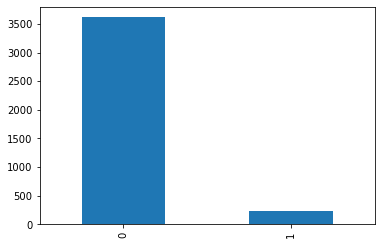

In [14]:
pd.value_counts(y_data_train).plot(kind='bar')

From the plot and count above, we can easily find that the data set is **imbalanced**. The number of true value is much smaller than the number of positive value. So, we need to deal with this imbalanced data set first in order to get better training models.

<Figure size 864x720 with 0 Axes>

<AxesSubplot:>

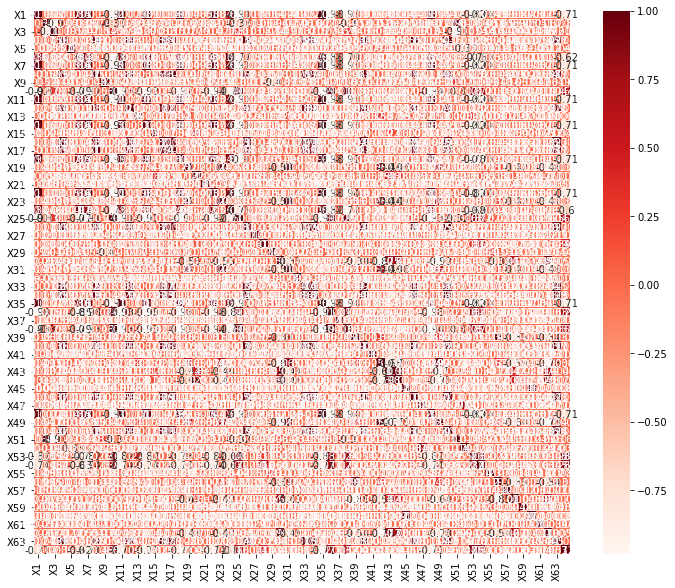

In [15]:
import seaborn as sns
plt.figure(figsize=(12,10))
cor = X_data.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [16]:
cor_target = abs(cor['X1'])

# Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
relevant_features

X1     1.000000
X6     0.863811
X7     0.999983
X10    0.924522
X11    0.999953
X14    0.999982
X18    0.993049
X22    0.997251
X24    0.835882
X25    0.906920
X35    0.997084
X36    0.982821
X38    0.926038
X48    0.996739
X53    0.819271
X54    0.739949
X64    0.712949
Name: X1, dtype: float64

From the correlations above, we can easily find there are some features that are highly correlated with each other, such as **Feature X1** has nearly perfect correlations with **Feature X7, X11, X14, X18, X22, X35, X36,** and **X48**. We could try to combine these festures into one synthetic feature while preparing the data, which could efficiently decrease our data dimension.

So, it is possible for us to express some of features by others. We will do **Principle Component Analysis(PCA)** in the following data processing section.

## Prepare the Data

We will deal with the data using two ways. 

- Use **PCA** directly, and use class weight to deal with imbalanced data when training models
- use **SMOTE** to deal with imbalanced data set and then apply **PCA**.

For SMOTE, we will explain this method when we use it.

**only apply PCA**

We will use the PCA to reduce the dimensions. Original data set has 64 features, which is hard to visualize. Our purpose is to find some linear relationships between original features, and then generate synthetic features accordingly. Then we could visualize the data after dimension reduction, which will help us find apporiate model better.

In [17]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

pca = PCA(n_components = 0.95)
X_data_train = normalize(X_data_train)
pca.fit(X_data_train)

PCA(n_components=0.95)

In [18]:
pca.n_components_

3

In [19]:
X_reduced = pca.transform(X_data_train)
X_reduced.shape
X_reduced

(3854, 3)

array([[ 0.80467551,  1.31076657,  0.01298691],
       [-0.59969395,  0.0139958 ,  0.00803418],
       [-0.07439748, -0.47004101,  0.01750258],
       ...,
       [-0.56183937, -0.05626848,  0.01166989],
       [-0.50818012, -0.13570336,  0.01294075],
       [ 1.11990227, -0.11392831,  0.0157686 ]])

In [20]:
pca.explained_variance_
pca.explained_variance_ratio_
pca.explained_variance_ratio_.sum()

array([0.36951185, 0.27812528, 0.01654572])

array([0.52869351, 0.3979386 , 0.02367343])

0.9503055379789506

Text(0.5, 1.0, 'First 3 PCA components')

Text(0.5, 0, 'Original feature #')

Text(0, 0.5, 'Original feature value')

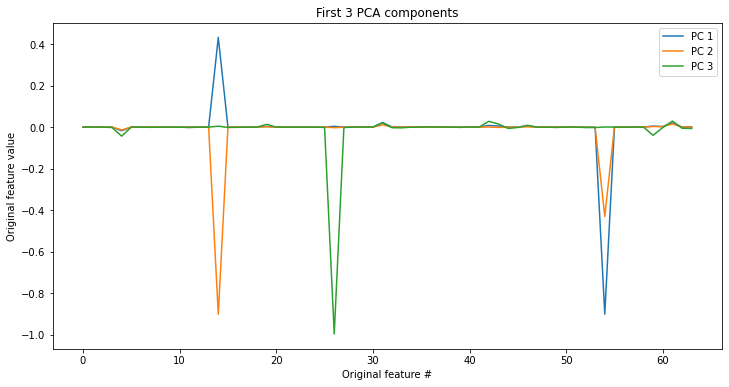

In [21]:
fig, ax = plt.subplots(1,1, figsize=(12,6))
ax.set_title('First {0} PCA components'.format(np.shape(np.transpose(pca.components_))[-1]))

ax.plot(np.transpose(pca.components_) )
ax.set_xlabel("Original feature #")
ax.set_ylabel("Original feature value")
ax.legend(["PC 1", "PC 2", "PC 3"])

From the plot above, four synthetic features after PCA are quite obvious,

- PC 1 mostly affects on the original features 10 to 20 and 50 to 60.
- PC 2 influces features 10 to 20 negatively, similar to PC1, but opposite direction. PC 2 also affects on original freatures 50 to 60. 
- PC 3 has a negative effect on original features 20 to 30.

**SMOTE and PCA**

For this SMOTE is an package that helps us deal with imbalanced data. The basic algorithm of SMOTE is to generate minority class examples, in this case, the class 1 of y_data. It uses nearest neighbor and synthesises new minority instances between existing (real) minority instances. We will use the SMOTE to increase the number of class 1 sample from 240 to 3614, then the data is balanced.

In [22]:
from imblearn.over_sampling import SMOTE
smo = SMOTE(random_state=42)
X_smo, y_smo = smo.fit_resample(X_data_train, y_data_train)
X_smo.shape
y_smo.shape

(7228, 64)

(7228,)

In [23]:
y_smo.value_counts()

1    3614
0    3614
Name: Bankrupt, dtype: int64

In [24]:
X_smo

array([[-1.13606363e-04,  4.68425668e-04, -1.59970025e-04, ...,
         7.53685487e-02,  4.68363473e-04,  3.08343692e-04],
       [ 2.17292618e-05,  9.36271468e-06,  2.94686466e-05, ...,
         2.68336764e-03,  9.60302127e-04,  1.86918200e-04],
       [ 4.76923493e-06,  1.40993946e-04,  2.63203176e-05, ...,
         2.41801701e-02,  5.11169533e-04,  1.74559114e-03],
       ...,
       [-2.97931342e-04,  6.05292938e-04,  1.46070944e-04, ...,
         1.12944274e-01,  2.48105640e-03,  1.25761092e-02],
       [ 5.13219654e-07,  2.61761048e-05,  6.82659878e-06, ...,
         1.01724005e-02,  8.96174714e-05,  1.18486713e-04],
       [ 4.26481028e-06,  1.30392125e-04, -1.07937766e-05, ...,
         1.07336172e-02,  1.41645742e-03,  1.20956577e-03]])

In [25]:
y_smo

0       0
1       0
2       0
3       0
4       0
       ..
7223    1
7224    1
7225    1
7226    1
7227    1
Name: Bankrupt, Length: 7228, dtype: int64

Then, we will reduce dimensions of the origin features. Before PCA, we will do the data standardization first in order to get better result.

In [26]:
X_smo = normalize(X_smo)
X_smo

array([[-1.13606363e-04,  4.68425668e-04, -1.59970025e-04, ...,
         7.53685487e-02,  4.68363473e-04,  3.08343692e-04],
       [ 2.17292618e-05,  9.36271468e-06,  2.94686466e-05, ...,
         2.68336764e-03,  9.60302127e-04,  1.86918200e-04],
       [ 4.76923493e-06,  1.40993946e-04,  2.63203176e-05, ...,
         2.41801701e-02,  5.11169533e-04,  1.74559114e-03],
       ...,
       [-3.33933544e-04,  6.78436899e-04,  1.63722244e-04, ...,
         1.26592528e-01,  2.78086874e-03,  1.40958138e-02],
       [ 5.14490670e-07,  2.62409314e-05,  6.84350523e-06, ...,
         1.01975930e-02,  8.98394139e-05,  1.18780152e-04],
       [ 4.26515512e-06,  1.30402667e-04, -1.07946494e-05, ...,
         1.07344850e-02,  1.41657194e-03,  1.20966357e-03]])

Perform PCA.

In [27]:
pca = PCA(n_components = 0.95)
pca.fit(X_smo)

PCA(n_components=0.95)

In [28]:
pca.n_components_

3

In [29]:
# Transform 
X_smo_reduced = pca.transform(X_smo)
X_smo_reduced.shape
X_smo_reduced

(7228, 3)

array([[ 1.14881708,  0.48242389, -0.0455863 ],
       [-0.37412555, -0.67308436, -0.047695  ],
       [-0.75766257, -0.07211847,  0.00363185],
       ...,
       [ 0.74864324, -0.60956943,  0.16116946],
       [-0.6331334 , -0.39179582, -0.02988388],
       [-0.41229529,  0.91116176, -0.03646896]])

From above transformation, we successfully reduced the data set from **64** dimensions to **3** dimensions. 

Next, we will plot the cumulative variance as a function of number of synthetic features. This can help us to determine how many synthetic features to keep.

Text(0.5, 0, '# of components')

Text(0, 0.5, 'Fraction total variance')

To capture 95% of variance we need 3 synthetic features.


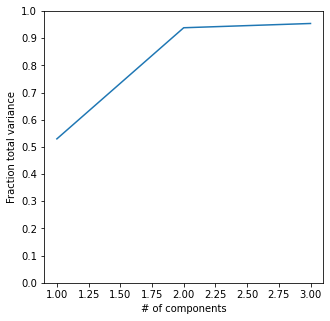

In [30]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
x  = range(1, 1 + cumsum.shape[0])
        
fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.plot(x, cumsum)

ax.set_xlabel("# of components")
ax.set_ylabel("Fraction total variance")
ax.set_yticks( np.linspace(0,1,11)  )

variance_goal_pct = 95
features_for_goal = np.argmax(cumsum >= .01*variance_goal_pct) + 1
print("To capture {f:d}% of variance we need {d:d} synthetic features.".format(f=variance_goal_pct, d=features_for_goal))


So, we need only about 4.69% of the origin 64 features to capture 95% of the variance. Then we could plot 3 synthetic components. 

Text(0.5, 1.0, 'First 3 PCA components')

Text(0.5, 0, 'Original feature #')

Text(0, 0.5, 'Original feature value')

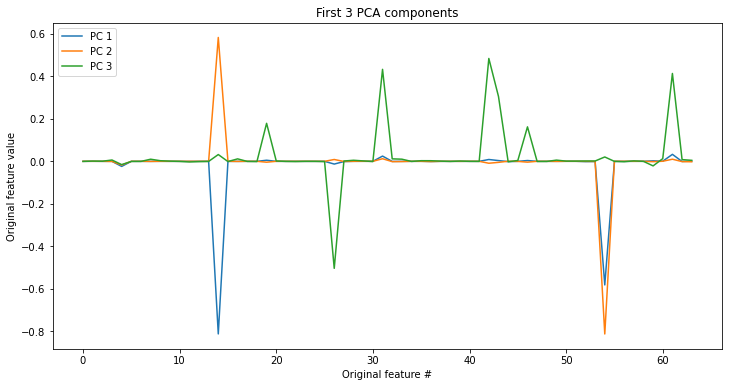

In [31]:
fig, ax = plt.subplots(1,1, figsize=(12,6))
ax.set_title('First {0} PCA components'.format(np.shape(np.transpose(pca.components_))[-1]))

ax.plot(np.transpose(pca.components_) )
ax.set_xlabel("Original feature #")
ax.set_ylabel("Original feature value")
ax.legend(["PC 1", "PC 2", "PC 3"])

In [32]:
pca.explained_variance_
pca.explained_variance_ratio_
pca.explained_variance_ratio_.sum()

array([0.4908279 , 0.37892028, 0.01454428])

array([0.52955355, 0.40881656, 0.01569181])

0.9540619180648878

From the plot above, we can easily see that each synthetic feature has its specific features. For example:

- PC1 has a huge negative effects on orginal features around 10 to 20. 
- PC2 has bigger effects on orginal features around 10 to 20 and 50 to 60.
- These two components, PC1 and PC2 keep over 90% of the orginal information.
- PC3 has effects all over the orginal features. 

Then we will try to plot the data set after PCA.

Text(0.5, 0, 'PC 1')

Text(0.5, 0, 'PC 2')

Text(0.5, 0, 'PC 3')

<ipython-input-33-e7dcdf2408ec>:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


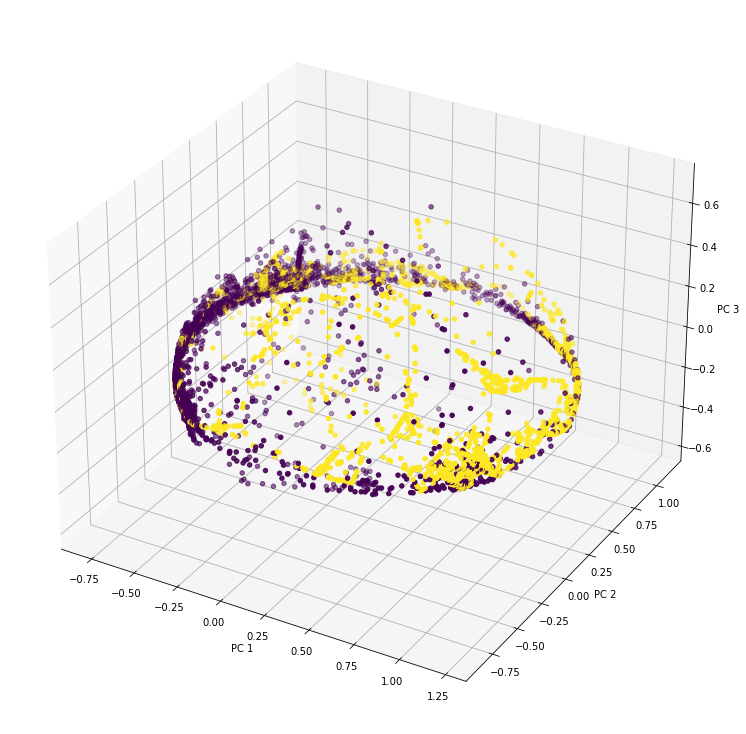

In [33]:
from mpl_toolkits.mplot3d.axes3d import Axes3D
fig = plt.figure(figsize=(10,20))
ax = Axes3D(fig)
x1 = pd.DataFrame(X_smo_reduced)[0] 
y1 = pd.DataFrame(X_smo_reduced)[1]
z1 = pd.DataFrame(X_smo_reduced)[2]

ax.scatter(x1, y1, z1, c=y_smo)

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')

fig.show()

From the visualization above, reducing the dimension to 3 makes the data set easier to be visualized. And we can get a basic idea about how the data is classfied There is no obvious classification between two groups of y data. So we might need to pay more efforts to train the model in order to get an better model.

## Train a Model

In order to get better model, we will try multiple models and choose one that has the best performance. 

- **Logistic Regression Model with class weight**

In this model, we will use the X_data_train and y_data_train to train the model. And for the imbalanced data, we will mainly use class_weight to deal with it. We will set the class_weight = 'balanced' and check the accuray, recall and precision that this model will get.

In [34]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(solver='lbfgs',class_weight='balanced', max_iter=10000)
clf.fit(X_data_train, np.array(y_data_train))

LogisticRegression(class_weight='balanced', max_iter=10000)

In [35]:
y_pred = clf.predict(X_data_test)

In [36]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
name = "LogsticRegression without PCA"
accuracy = accuracy_score(y_data_test, y_pred)

# recall_
recall = recall_score(np.array(y_data_test), y_pred,pos_label=1, average="binary")

# precision
precision = precision_score(np.array(y_data_test), y_pred, pos_label=1, average="binary")

#F1 score
f1 = f1_score(y_data_test, y_pred, pos_label=1, average='binary')

print("\t{m:s} Accuracy: {a:3.1%}, Recall {r:3.1%}, Precision {p:3.1%}, F1score {f:3.1%}".format(m=name,
                                                                            a=accuracy,
                                                                            r=recall,
                                                                            p=precision,
                                                                            f=f1
                                                                            )
         )

	LogsticRegression without PCA Accuracy: 82.7%, Recall 58.8%, Precision 22.3%, F1score 32.4%


Train LogisticRegression using cross validation.

In [37]:
from sklearn.model_selection import cross_val_score
cross_val_scores = None
k = 5
cross_val_scores = cross_val_score(clf, X_data_train, y_data_train, cv=k)

print("Model: {m:s} avg cross validation score={s:3.2f}\n".format(m=name, s=cross_val_scores.mean()) )

Model: LogsticRegression without PCA avg cross validation score=0.80



Now we got the baseline model. Then we will try to train with model with data set after SMOTE and PCA in order to get better model performance.

- **Logistic Regression Model with SMOTE and PCA**

In [38]:
clf_LR = LogisticRegression(solver='lbfgs')
clf_LR.fit(X_smo_reduced, np.array(y_smo))

LogisticRegression()

Perform the same process to test set as to train set.

In [39]:
X_data_test = normalize(X_data_test)

In [40]:
X_data_test_reduced = pca.transform(X_data_test)
X_data_test_reduced.shape

(964, 3)

In [41]:
y_LRpred = clf_LR.predict(X_data_test_reduced)

In [42]:
from sklearn.metrics import confusion_matrix
name = "LogsticRegression with PCA"

# Compute metrics
# accuracy
accuracy_LR = accuracy_score(y_data_test, y_LRpred)

# recall_
recall_LR = recall_score(np.array(y_data_test), y_LRpred, pos_label=1, average="binary")

# precision
precision_LR = precision_score(np.array(y_data_test), y_LRpred, pos_label=1, average="binary")

#F1 score
f1_LR = f1_score(y_data_test, y_LRpred, pos_label=1, average='binary')

print("\t{m:s} Accuracy: {a:3.1%}, Recall {r:3.1%}, Precision {p:3.1%}, F1score {f:3.1%}".format(m=name,
                                                                            a=accuracy_LR,
                                                                            r=recall_LR,
                                                                            p=precision_LR,
                                                                            f=f1_LR
                                                                            )
         )
confusion_matrix(y_data_test, y_LRpred)

	LogsticRegression with PCA Accuracy: 80.7%, Recall 60.3%, Precision 20.5%, F1score 30.6%


array([[737, 159],
       [ 27,  41]])

Train LogisticRegression model using cross validation.

In [43]:
cross_val_scores = None
k = 5
cross_val_scores = cross_val_score(clf_LR, X_smo_reduced, y_smo, cv=k)

print("Model: {m:s} avg cross validation score={s:3.2f}\n".format(m=name, s=cross_val_scores.mean()) )

Model: LogsticRegression with PCA avg cross validation score=0.72



- **Support Vector Machine(SVM) with class weight**

In [44]:
from sklearn import svm
svm_cw = svm.SVC(kernel='linear', class_weight='balanced')
svm_cw.fit(X_reduced, y_data_train)

SVC(class_weight='balanced', kernel='linear')

In [45]:
y_cwpred = svm_cw.predict(X_data_test_reduced)

In [46]:
name = "SVM with class weight"

# Compute metrics
# accuracy
accuracy_cw = accuracy_score(y_data_test, y_cwpred)

# recall_
recall_cw = recall_score(np.array(y_data_test), y_cwpred, pos_label=1, average="binary")

# precision
precision_cw = precision_score(np.array(y_data_test), y_cwpred, pos_label=1, average="binary")

#F1 score
f1_cw = f1_score(y_data_test, y_cwpred, pos_label=1, average='binary')

print("\t{m:s} Accuracy: {a:3.1%}, Recall {r:3.1%}, Precision {p:3.1%}, F1score {f:3.1%}".format(m=name,
                                                                            a=accuracy_cw,
                                                                            r=recall_cw,
                                                                            p=precision_cw,
                                                                            f=f1_cw
                                                                            )
         )
confusion_matrix(y_data_test, y_cwpred)

	SVM with class weight Accuracy: 83.1%, Recall 36.8%, Precision 17.2%, F1score 23.5%


array([[776, 120],
       [ 43,  25]])

Train model using cross validation

In [47]:
cross_val_scores = None
k = 5
cross_val_scores = cross_val_score(svm_cw, X_reduced, y_data_train, cv=k)

print("Model: {m:s} avg cross validation score={s:3.2f}\n".format(m=name, s=cross_val_scores.mean()) )

Model: SVM with class weight avg cross validation score=0.83



We can find SVM with class weight has higher accuracy than LogisticRegression model. The accuracy increased from 80.6% to 83.9%. However, the recall and precision also dropped. Above models have their advantages and disadvantages, so that we need to make trade-off between them. We will train and test more models in following.

- **Support Vector Machine(SVM) with SMOTE and PCA**

In [48]:
from time import time
import datetime

Kernel = ["linear","poly","rbf","sigmoid"]
for kernel in Kernel:
    time0 = time()
    clf = svm.SVC(kernel=kernel,
             gamma="auto",
             degree=1,
             cache_size=5000
             ).fit(X_smo_reduced, y_smo)
    print("The accuracy under kernel %s is %f" % (kernel, clf.score(X_data_test_reduced, y_data_test)))
    print(datetime.datetime.fromtimestamp(time()-time0).strftime("%M:%S:%f"))

The accuracy under kernel linear is 0.827801
00:01:387426
The accuracy under kernel poly is 0.827801
00:01:245766
The accuracy under kernel rbf is 0.819502
00:01:742164
The accuracy under kernel sigmoid is 0.651452
00:01:865561


Above result shows that all four kernels in SVM perform as good as each other, so it might not be an issue to choose one from them. We will use **'rbf' kernel** in the following SVM model training process.

Then we will find the best gamma for SVM model.

In [49]:
score = []
gamma_range = np.logspace(-10, 1, 50)
for i in gamma_range:
    clf = svm.SVC(kernel='linear', gamma=i, cache_size=5000).fit(X_smo_reduced, y_smo)
    score.append(clf.score(X_data_test_reduced, y_data_test))

In [50]:
print(max(score), gamma_range[score.index(max(score))])

0.8278008298755186 1e-10


The best result we can get when changing the gamma is the same as previous. So, we will not change the gamma parameter.

In [51]:
clf_svm = svm.SVC(kernel='linear')
clf_svm.fit(X_smo_reduced, y_smo)

SVC(kernel='linear')

In [52]:
y_svmpred = clf_svm.predict(X_data_test_reduced)

In [53]:
name = "SVM"

# Compute metrics
# accuracy
accuracy_svm = accuracy_score(y_data_test, y_svmpred)

# recall_
recall_svm = recall_score(y_data_test, y_svmpred, pos_label=1, average="binary")

# precision
precision_svm = precision_score(y_data_test, y_svmpred, pos_label=1, average="binary")

#F1 score
f1_svm = f1_score(y_data_test, y_svmpred, pos_label=1, average='binary')

print("\t{m:s} Accuracy: {a:3.1%}, Recall {r:3.1%}, Precision {p:3.1%}, F1score {f:3.1%}".format(m=name,
                                                                            a=accuracy_svm,
                                                                            r=recall_svm,
                                                                            p=precision_svm,
                                                                            f=f1_svm
                                                                            )
         )

	SVM Accuracy: 82.8%, Recall 52.9%, Precision 21.2%, F1score 30.3%


Train SVM model using cross validation

In [54]:
cross_val_scores = None
k = 5
cross_val_scores = cross_val_score(clf_svm, X_smo_reduced, y_smo, cv=k)

print("Model: {m:s} avg cross validation score={s:3.2f}\n".format(m=name, s=cross_val_scores.mean()) )

Model: SVM avg cross validation score=0.73



Both SVM models have better performance than LogisticRegression models. SVM with SMOTE and PCA has similar accuracy, but much higher recall. From my perspective, it performs well. Since SMOTE sacrifices part of the accuracy to deal with imbalanced data set, it is reasonable that the accuracy is a little bit low.

- **K-Nearest Neighbors**

In [55]:
from sklearn.neighbors import KNeighborsClassifier
clf_knn = KNeighborsClassifier(n_neighbors=3)
clf_knn.fit(X_smo_reduced, y_smo)

KNeighborsClassifier(n_neighbors=3)

In [56]:
y_knnpred = clf_knn.predict(X_data_test_reduced)

In [57]:
name = "KNN"

# Compute metrics
# accuracy
accuracy_knn = accuracy_score(y_data_test, y_knnpred)

# recall_
recall_knn = recall_score(y_data_test, y_knnpred, pos_label=1, average="binary")

# precision
precision_knn = precision_score(y_data_test, y_knnpred, pos_label=1, average="binary")

#F1 score
f1_knn = f1_score(y_data_test, y_knnpred, pos_label=1, average='binary')

print("\t{m:s} Accuracy: {a:3.1%}, Recall {r:3.1%}, Precision {p:3.1%}, F1score {f:3.1%}".format(m=name,
                                                                            a=accuracy_knn,
                                                                            r=recall_knn,
                                                                            p=precision_knn, f=f1_knn
                                                                            )
         )

	KNN Accuracy: 74.9%, Recall 54.4%, Precision 14.9%, F1score 23.4%


In [58]:
cross_val_scores = None
k = 5
cross_val_scores = cross_val_score(clf_knn, X_smo_reduced, y_smo, cv=k)

print("Model: {m:s} avg cross validation score={s:3.2f}\n".format(m=name, s=cross_val_scores.mean()) )

Model: KNN avg cross validation score=0.83



- **Random Forest Classifier**

In [59]:
from sklearn.ensemble import RandomForestClassifier
clf_RF = RandomForestClassifier(n_estimators=30, random_state=42)
clf_RF.fit(X_smo_reduced, y_smo)

RandomForestClassifier(n_estimators=30, random_state=42)

In [60]:
y_RFpred = clf_RF.predict(X_data_test_reduced)

In [61]:
name = "RandomForestClassifier"

# Compute metrics
# accuracy
accuracy_RF = accuracy_score(y_data_test, y_RFpred)

# recall_
recall_RF = recall_score(y_data_test, y_RFpred, pos_label=1, average="binary")

# precision
precision_RF = precision_score(y_data_test, y_RFpred, pos_label=1, average="binary")

#F1 score
f1_RF = f1_score(y_data_test, y_RFpred, pos_label=1, average='binary')

print("\t{m:s} Accuracy: {a:3.1%}, Recall {r:3.1%}, Precision {p:3.1%}, F1score {f:3.1%}".format(m=name,
                                                                            a=accuracy_RF,
                                                                            r=recall_RF,
                                                                            p=precision_RF, 
                                                                            f=f1_RF
                                                                            )
         )

	RandomForestClassifier Accuracy: 80.0%, Recall 47.1%, Precision 16.9%, F1score 24.9%


In [62]:
cross_val_scores = None
k = 5
cross_val_scores = cross_val_score(clf_RF, X_smo_reduced, y_smo, cv=k)

print("Model: {m:s} avg cross validation score={s:3.2f}\n".format(m=name, s=cross_val_scores.mean()) )

Model: RandomForestClassifier avg cross validation score=0.84



- **GaussianNB** 

In [63]:
from sklearn.naive_bayes import GaussianNB
clf_GNB = GaussianNB()
clf_GNB.fit(X_smo_reduced, y_smo)

GaussianNB()

In [64]:
y_GNBpred = clf_GNB.predict(X_data_test_reduced)

In [65]:
name = "GaussianNB"

# Compute metrics
# accuracy
accuracy_GNB = accuracy_score(y_data_test, y_GNBpred)

# recall_
recall_GNB = recall_score(y_data_test, y_GNBpred, pos_label=1, average="binary")

# precision
precision_GNB = precision_score(y_data_test, y_GNBpred, pos_label=1, average="binary")

#F1 score
f1_GNB = f1_score(y_data_test, y_GNBpred, pos_label=1, average='binary')

print("\t{m:s} Accuracy: {a:3.1%}, Recall {r:3.1%}, Precision {p:3.1%}, F1score {f:3.1%}".format(m=name,
                                                                            a=accuracy_GNB,
                                                                            r=recall_GNB,
                                                                            p=precision_GNB, 
                                                                            f=f1_GNB
                                                                            )
         )

	GaussianNB Accuracy: 81.1%, Recall 51.5%, Precision 19.0%, F1score 27.8%


In [66]:
cross_val_scores = None
k = 5
cross_val_scores = cross_val_score(clf_GNB, X_smo_reduced, y_smo, cv=k)

print("Model: {m:s} avg cross validation score={s:3.2f}\n".format(m=name, s=cross_val_scores.mean()) )

Model: GaussianNB avg cross validation score=0.72



- **AdaBoost Classifier**

In [67]:
from sklearn.ensemble import AdaBoostClassifier
clf_AB = AdaBoostClassifier()
clf_AB.fit(X_smo_reduced, y_smo)

AdaBoostClassifier()

In [68]:
y_ABpred = clf_AB.predict(X_data_test_reduced)

In [69]:
name = "AdaBoost Classifier"

# Compute metrics
# accuracy
accuracy_AB = accuracy_score(y_data_test, y_ABpred)

# recall_
recall_AB = recall_score(y_data_test, y_ABpred, pos_label=1, average="binary")

# precision
precision_AB = precision_score(y_data_test, y_ABpred, pos_label=1, average="binary")

#F1 score
f1_AB = f1_score(y_data_test, y_ABpred, pos_label=1, average='binary')

print("\t{m:s} Accuracy: {a:3.1%}, Recall {r:3.1%}, Precision {p:3.1%}, F1score {f:3.1%}".format(m=name,
                                                                            a=accuracy_AB,
                                                                            r=recall_AB,
                                                                            p=precision_AB, 
                                                                            f=f1_AB
                                                                            )
     )

	AdaBoost Classifier Accuracy: 78.7%, Recall 67.6%, Precision 20.1%, F1score 31.0%


In [70]:
cross_val_scores = None
k = 5
cross_val_scores = cross_val_score(clf_AB, X_smo_reduced, y_smo, cv=k)

print("Model: {m:s} avg cross validation score={s:3.2f}\n".format(m=name, s=cross_val_scores.mean()) )

Model: AdaBoost Classifier avg cross validation score=0.75



- **Decision Tree Classifier**

In [71]:
from sklearn.tree import DecisionTreeClassifier
clf_DT = DecisionTreeClassifier()
clf_DT.fit(X_smo_reduced, y_smo)

DecisionTreeClassifier()

In [72]:
y_DTpred = clf_DT.predict(X_data_test_reduced)

In [73]:
name = "Decision Tree Classifier"

# Compute metrics
# accuracy
accuracy_DT = accuracy_score(y_data_test, y_DTpred)

# recall_
recall_DT = recall_score(y_data_test, y_DTpred, pos_label=1, average="binary")

# precision
precision_DT = precision_score(y_data_test, y_DTpred, pos_label=1, average="binary")

#F1 score
f1_DT = f1_score(y_data_test, y_DTpred, pos_label=1, average='binary')

print("\t{m:s} Accuracy: {a:3.1%}, Recall {r:3.1%}, Precision {p:3.1%}, F1score {f:3.1%}".format(m=name,
                                                                            a=accuracy_DT,
                                                                            r=recall_DT,
                                                                            p=precision_DT, 
                                                                            f=f1_DT
                                                                            )
     )

	Decision Tree Classifier Accuracy: 77.7%, Recall 51.5%, Precision 16.1%, F1score 24.6%


In [74]:
cross_val_scores = None
k = 5
cross_val_scores = cross_val_score(clf_DT, X_smo_reduced, y_smo, cv=k)

print("Model: {m:s} avg cross validation score={s:3.2f}\n".format(m=name, s=cross_val_scores.mean()) )

Model: Decision Tree Classifier avg cross validation score=0.80



We trained lots of classification models above. In order to compare the models better, we will conclude all the models below, in the **Conclude the Models** section. And after comparing, we can make the decision about which one we will use in our **MyModel** function.

## Conclude the Model

In conclusion, all the maodel we have are:

- Logistic Regression Model with class weight
- Logistic Regression Model with SMOTE and PCA
- Support Vector Machine(SVM) with class weight
- Support Vector Machine(SVM) with SMOTE and PCA
- K-Nearest Neighbors
- Random Forest Classifier
- GaussianNB
- AdaBoost Classifier
- Decision Tree Classifier


In [75]:
d = {'Accuracy': [accuracy, accuracy_LR, accuracy_cw, accuracy_svm, 
                  accuracy_knn, accuracy_RF, accuracy_GNB, accuracy_AB, accuracy_DT], 
     'Recall': [recall, recall_LR, recall_cw, recall_svm, 
                  recall_knn, recall_RF, recall_GNB, recall_AB, recall_DT], 
     'Precision': [precision, precision_LR, precision_cw, precision_svm, 
                  precision_knn, precision_RF, precision_GNB, precision_AB, precision_DT],
    'F1score':[f1, f1_LR, f1_cw, f1_svm, f1_knn, f1_RF, f1_GNB, f1_AB, f1_DT]}
index = ['LR with class weight','LogisticRegression', 'SVM with class weight',
           'SVM', 'KNN', 'RandomForest', 'GaussianNB', 'AdaBoost', 'DecisionTree']
df = pd.DataFrame(data=d, index=index)
df

,Accuracy,Recall,Precision,F1score
LR with class weight,0.826763,0.588235,0.223464,0.323887
LogisticRegression,0.807054,0.602941,0.205000,0.305970
SVM with class weight,0.830913,0.367647,0.172414,0.234742
SVM,0.827801,0.529412,0.211765,0.302521
KNN,0.748963,0.544118,0.149194,0.234177
RandomForest,0.799793,0.470588,0.169312,0.249027
GaussianNB,0.811203,0.514706,0.190217,0.277778
AdaBoost,0.787344,0.676471,0.200873,0.309764
DecisionTree,0.776971,0.514706,0.161290,0.245614


In [76]:
df.sort_values(by=['Recall', 'Accuracy'], ascending=False)

,Accuracy,Recall,Precision,F1score
AdaBoost,0.787344,0.676471,0.200873,0.309764
LogisticRegression,0.807054,0.602941,0.205000,0.305970
LR with class weight,0.826763,0.588235,0.223464,0.323887
KNN,0.748963,0.544118,0.149194,0.234177
SVM,0.827801,0.529412,0.211765,0.302521
GaussianNB,0.811203,0.514706,0.190217,0.277778
DecisionTree,0.776971,0.514706,0.161290,0.245614
RandomForest,0.799793,0.470588,0.169312,0.249027
SVM with class weight,0.830913,0.367647,0.172414,0.234742


Also, we will assume it is 5 times worse to *fail to identify a company that will go bankrupt*
than it is to fail to identify a company that won't go bankrupt. Recall is more important than precision in this case, because it is risky that we cannot identify the company will be bankrupt and still lend money to it. We might lose lots of money under such situation. Based on the calculation method of F1 score, we will change the weight of recall and precision in the equation.

$$\ score = \frac{Precision+5⋅Recall}{6} \,$$
	

In [77]:
df['score'] = (df['Precision'] + df['Recall'])/6
df

,Accuracy,Recall,Precision,F1score,score
LR with class weight,0.826763,0.588235,0.223464,0.323887,0.135283
LogisticRegression,0.807054,0.602941,0.205000,0.305970,0.134657
SVM with class weight,0.830913,0.367647,0.172414,0.234742,0.090010
SVM,0.827801,0.529412,0.211765,0.302521,0.123529
KNN,0.748963,0.544118,0.149194,0.234177,0.115552
RandomForest,0.799793,0.470588,0.169312,0.249027,0.106650
GaussianNB,0.811203,0.514706,0.190217,0.277778,0.117487
AdaBoost,0.787344,0.676471,0.200873,0.309764,0.146224
DecisionTree,0.776971,0.514706,0.161290,0.245614,0.112666


In [78]:
df.sort_values(by=['score', 'Accuracy'], ascending=False)

,Accuracy,Recall,Precision,F1score,score
AdaBoost,0.787344,0.676471,0.200873,0.309764,0.146224
LR with class weight,0.826763,0.588235,0.223464,0.323887,0.135283
LogisticRegression,0.807054,0.602941,0.205000,0.305970,0.134657
SVM,0.827801,0.529412,0.211765,0.302521,0.123529
GaussianNB,0.811203,0.514706,0.190217,0.277778,0.117487
KNN,0.748963,0.544118,0.149194,0.234177,0.115552
DecisionTree,0.776971,0.514706,0.161290,0.245614,0.112666
RandomForest,0.799793,0.470588,0.169312,0.249027,0.106650
SVM with class weight,0.830913,0.367647,0.172414,0.234742,0.090010


<font size=5>**Conclusion**</font>

Compared with models, recall is my first choosing standard, then the accuracy and the adjusted score. Among these 9 classification models, Logistic Regression model generally outperforms than others. Logistic Regression after SMOTE and PCA has similar accuracy with balanced class weight, but the former model has higher recall. 

So we will choose **Logistic Regression with SMOTE and PCA** as our model to predict if the company is going to bankrupt in the following year.


In [79]:
def MyModel(X):
    # It should create an array of predictions; we initialize it to the empty array for convenience
   
    predictions = []
    
    # YOUR CODE GOES HERE
    X = X.apply(pd.to_numeric, errors='coerce')
    X = X.fillna(0)
    X = normalize(X.loc[:,'X1':'X64'])
    X_reduced = pca.transform(X)
    predictions = clf_LR.predict(X_reduced)
    
    return predictions

# Check your work: predict and evaluate metrics on *your* test examples

Although only the instructors have the correct labels for the holdout dataset, you may want
to create your own test dataset on which to evaluate your out of sample metrics.

If you choose to do so, you can evaluate your models using the same metrics that the instructors will use.

- Test whether your implementation of `MyModel` works
- See the metrics  your model produces

The following cell
- Assumes that you have created `X_test, y_test` as your proxy for an out of sample dataset
    - It serves the same function as `X_hold`, the holdout dataset, but you have the associated target (only the instructors have `y_hold`)

In [80]:
X_test = pd.read_csv( os.path.join(DATA_DIR, "holdout", '5th_yr.csv') )
y = pd.read_csv('./Data/holdout/5th_yr_with_target.csv')
y_test = y['Bankrupt']

In [81]:
y_test_pred = MyModel(X_test)
y_test_pred

array([0, 1, 0, ..., 1, 0, 0])

In [82]:
name = "LogsticRegression with PCA"
accuracy_test = accuracy_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred, pos_label=1, average="binary")
precision_test = precision_score(y_test,   y_test_pred, pos_label=1, average="binary")

print("\t{m:s} Accuracy: {a:3.1%}, Recall {r:3.1%}, Precision {p:3.1%}".format(m=name,
                                                                            a=accuracy_test,
                                                                            r=recall_test,
                                                                            p=precision_test
                                                                            )
         )

	LogsticRegression with PCA Accuracy: 78.0%, Recall 65.7%, Precision 24.6%


Through the out-of-sample test, we can see that our MyModel function works well, and the recall, which is considered the most important in this case, is also in a decent number. Both accuracy and precision are acceptable. We sacrifice part of accuracy and precision to gain higher recall, which is the trade-off we have to do in order to classify companies that might bankrupt in the following year as much as possible.